## Lecture 4.4: Least Square Classification from Scratch
### Least Square Classification from scratch
### Background
We will implement least square classification from scratch in this notebook.

A few points to recall
- Least square classification is used for estimating parameters of discriminant function from the given training data.
- Least Square classification adapts linear regression model for classification.
  - It uses **least square error** as a loss function.
  - It uses **normal equation** method and **gradient descent** for estimating model parameters or weight vector.
- Since its a classification algorithm, we would use classification related evaluation metrics like precision, recall, F-1 score, AUC-ROC/PR and accuracy.

Additionally note that:
- We make use of polynomial feature transformation to obtain new features and then use the representation to learn non-linear decision boundaries between classes.
$$y=w_0+\mathbf{w}^T\phi(\mathbf{x})$$
where, $\phi(\mathbf{x})$ is a polynomial feature transformation.
- We can tackle issues of overfitting by using ridge or lasso regularization just like linear regression model

In [1]:
#@title [Import libraries]
from IPython.display import display, Math, Latex
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

We will reuse the code for polynomial transformation from the last week

In [2]:
import itertools
import functools

def get_combinations (x, degree):
    return itertools.combinations_with_replacement(x, degree)

def compute_new_features(items):
    # reduce (lambda x, y: x*y,[1,2,3,4,5]) calculates ((((1*2)*3)*4)*5)
    return functools.reduce(lambda x, y: x*y, items)

def polynomial_transform(x, degree, logging=False):
    # Converts to feature matrix
    if x.ndim == 1:
        x = x[:, None]
    x_t = x.transpose()
    features = [np.ones(len(x))] # Populates 1s as first feature for each example

    if logging:
        print("Input:", x)
    for degree in range(1,degree+1):
        for items in get_combinations(x_t, degree):
            features.append(compute_new_features(items))
            if logging:
                print(items, ":", compute_new_features(items))
    if logging:
        print(np.asarray(features).transpose())
    return np.asarray(features).transpose()

### Label Encoding
Since the output $y$ is a discrete quantity, we use one-hot encoding to represent label. For a **binary classification**,
- The label 0 is represented with [1, 0], and 
- The label 1 is represented with [0, 1].

The same scheme can be extended to the **multi-class setting**. In general for a class $k$ set up, we use one-hot encoding in $k$ component vector [$y_1, y_2, ... , y_k$]. For label $1 \le r \le k, y_r$ would be 1 and other components would be 0.

Concretely for three class classification setup,
- The label 0 is represented with [1, 0, 0]
- The label 1 is represented with [0, 1, 0]
- The label 2 is represented with [0, 0, 1]

In the following class, we implement LabelTransformer, that converts discrete label into one-hot encoding. We are using this implementation from [PRML github repo](https://github.com/ctgk/PRML/blob/main/prml/preprocess/label_transformer.py)

In [3]:
class LabelTransformer(object):
    """
    Label encoder decoder
    Attributes
    ----------
    n_classes : int
        number of classes, K
    """

    def __init__(self, n_classes:int=None):
        self.n_classes = n_classes

    @property
    def n_classes(self):
        return self.__n_classes

    @n_classes.setter
    def n_classes(self, K):
        self.__n_classes = K
        self.__encoder = None if K is None else np.eye(K)

    @property
    def encoder(self):
        return self.__encoder

    def encode(self, class_indices:np.ndarray):
        """
        encode class index into one-of-k code
        Parameters
        ----------
        class_indices : (N,) np.ndarray
            non-negative class index
            elements must be integer in [0, n_classes)
        Returns
        -------
        (N, K) np.ndarray
            one-of-k encoding of input
        """
        if self.n_classes is None:
            self.n_classes = np.max(class_indices) + 1

        return self.encoder[class_indices]

    def decode(self, onehot:np.ndarray):
        """
        decode one-of-k code into class index
        Parameters
        ----------
        onehot : (N, K) np.ndarray
            one-of-k code
        Returns
        -------
        (N,) np.ndarray
            class index
        """

        return np.argmax(onehot, axis=1)

Let's demonstrate the ``LabelTransformer`` with a couple of examples.

Binary classification setup:

In [4]:
binary_labels = LabelTransformer(2).encode(np.array([1, 0, 1, 0]))
binary_labels

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

Multiclass setup with three classes:

In [5]:
multiclass_labels = LabelTransformer(3).encode(np.array([1, 0, 1, 2]))
multiclass_labels

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

### Least square classification implementation

#### Training data
This representation of label has an impact on the learning setup. Now we have
- A feature matrix $\bf(X)$ of the shape $(n,m)$ where $n$ is the number of examples and $m$ is the number of features.
- A label matrix $\bf(Y)$ of shape $(n, k)$ where $k$ is the number of class labels. Note that this setup is similar to multiple regression.

#### Model
The label matrix is obtained by matrix multiplication of feature matrix and weight **matrix**. After adding a dummy feature to the feature matrix, its shape becomes $n \times (m+1)$
$$\mathbf{Y}_{n\times k} = \mathbf{X}_{n\times(m+1)}\mathbf{W}_{(m+1)\times k}$$
> There is one weight vector per output. Hence the total number of parameters to be estimated = $(m+1)\times k$
#### Loss Function
This results into the following loss matrix of shape $(k, k)$
$$\begin{align}
\mathbf{J(W)} &= \frac{1}{2}(\mathbf{Y}_{n \times k} - \mathbf{X}_{n \times (m+1)}\mathbf{W}_{(m+1 \times k)})^T(\mathbf{Y}_{n \times k} - \mathbf{X}_{n \times (m+1)}\mathbf{W}_{(m+1 \times k)}) + \color{b}{\frac{\lambda}{2}\mathbf{W}^T\mathbf{W}} \\
&= \frac{1}{2}(\mathbf{E}^T)_{k \times n}\mathbf{E}_{n \times k} + (\textcolor{blue}{\frac{\lambda}{2}\mathbf{W}^T\mathbf{W}})_{k \times k}
\end{align}
$$
#### Normal equation
There is almost no code change needed in ``fit`` function that uses normal equation method for paramter or weight vector estimation
$$\mathbf{W} = (\mathbf{X}^T\mathbf{X} + \textcolor{blue}{\mathbf{\lambda I}})^{-1}\mathbf{X}^T\mathbf{Y}$$
#### Iterative operation (GD, MBGD and SGD)
The gradient calulation (``calculate_gradient``) for iterative optimization is performed as follows: $\frac{\partial \mathbf{J(W)}}{\partial W} = \mathbf{X}^T(\mathbf{XW - Y}) + \textcolor{blue}{\mathbf{\lambda W}}$

And the new value of $\bf W$ is calculated in vectorized form:
$$\mathbf{W}^{(new)} := \mathbf{W}^{(old)} - \alpha \frac{\partial \mathbf{J(W)}}{\partial \mathbf{W}}$$
#### Inference
The ``predict`` function for this classification setup is expected to return a discrete quantity (unlike a real number in regression setup)
- We return the class label with the largest value of linear combination of features among all creatures.

#### Works for multi-class classification
> All other functions are adapted from ridge regression and multi regression notebook in the previous week

This implementation is generic enough to work on multi-class setup and also polynomial transformation followed by the least squares classification.

In [6]:
class LeastSquareClassification(object):
    '''
    LSC model
    -----------------------
    y = np.where(X@w >= 0, 1, 0)
    X: A feature matrix
    w: weight vector
    y: label vector
    '''

    def __init__(self):
        self.t0 = 200
        self.t1 = 100000
    
    def predict(self , X:np.ndarray) -> np.ndarray:
        '''
        Prediction of output label for a given input.

        Args:
            X: Feature matrix for given inputs.
        Returns:
            y: Output vector as predicted by the given model.
        '''
        assert X.shape[-1] == self.w.shape[0], f'X shape {X.shape} and w shape {self.w.shape}, are not compatible'
        return np.argmax(X @ self.w, axis=-1)
    
    def predict_internal(self , X:np.ndarray) -> np.ndarray:
        '''
        Prediction of output label for a given input.

        Args:
            X: Feature matrix for given inputs.
        Returns:
            y: Output vector as predicted by the given model.
        '''
        assert X.shape[-1] == self.w.shape[0], f'X shape {X.shape} and w shape {self.w.shape}, are not compatible'
        return X @ self.w
    
    def loss(self, X: np.ndarray, y: np.ndarray, reg_rate: float) -> float:
        '''
        Calculate the loss for a model based on known labels

        Args:
            X: Feature matrix for given inputs.
            y: Output label vector as predicted by the given model.
        Returns:
            Loss
        '''

        e = y - self.predict_internal(X)
        # return 0.5 * (np.transpose(e) @ e) # Old loss function
        return 0.5* (np.transpose(e)) @ e + (reg_rate/2) * (np.transpose(self.w) @ self.w)
    
    def rmse (self, X: np.ndarray, y: np.ndarray,reg_rate:float=0) -> float:
        '''
        Calculate the root mean squared error of predictions w.r.t actual label.

        Args:
            X: Feature matrix for given inputs.
            y: Output label vector as predicted by the given model
        Returns:
            Loss
        '''
        return np.sqrt((2/X.shape[0])) * self.loss(X,y,reg_rate)
    

    def fit (self, X: np.ndarray, y: np.ndarray, reg_rate: float) -> np.ndarray:
        '''
        Estimates the parameters of the linear regression model with normal equation

        Args:
            X: Feature matrix for given inputs.
            y: Output label vector as predicted by the given model
        Returns:
            weight vector
        '''
        #self.w = np.linalg.pinv(X) @ y
        #return self.w
        self.w = np.zeros((X.shape[1],y.shape[1]))
        eye = np.eye(np.size(X,1)) # Identity matrix
        self.w = np.linalg.solve(
            reg_rate * eye + X.T @ X,
            X.T @ y
        )
        return self.w
    

    def calculate_gradient(self, X: np.ndarray, y: np.ndarray, reg_rate: float) -> np.ndarray:
        '''
        Calculates gradients of loss function w.r.t weight vector on training set.
        Args:
            X: Feature matrix for given inputs.
            y: Output label vector as predicted by the given model
        Returns:
            a vector of gradients.
        '''
        #print(X.shape,y.shape)
        return np.transpose(X) @ (self.predict_internal(X) - y) + reg_rate * self.w
    
    def update_weights (self, grad:np.ndarray, lr: float) -> np.ndarray:
        '''
        Updates the weights based on the gradient of the loss function.

        Weight updates are carried out with the following formula:
            w_new := w_old - lr * grad
        Args:
            1. w: weight vector
            2. grad: gradient of loss w.r.t w
            3. lr: learning rate
        Returns:
            Updated weight vector
        '''
        return (self.w - lr * grad)

    def learning_schedule(self, t):
        return self.t0 / (t + self.t1)
    
    def gd(self, X: np.ndarray, y:np.ndarray, num_epochs:int, lr:float, reg_rate:float=0) -> np.ndarray:
        '''
        Estimates the parameters of linear regression model through gradient descent

        Args:
            X: Feature matrix for training data
            y: Label vector for training data
            num_epochs: Number of training steps
            lr: learning rate

        Returns:
            Weight vector: Final weight vector
        '''
        self.w = np.zeros((X.shape[1],y.shape[1]))
        self.w_all = []
        self.err_all = []
        for i in np.arange(0,num_epochs):
            dJdw = self.calculate_gradient(X, y,reg_rate)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X,y,reg_rate))
            self.w = self.update_weights(dJdw, lr)
        return self.w
    
    def mbgd (self, X:np.ndarray, y:np.ndarray, num_epochs:int, batch_size:int,reg_rate:float=0) -> np.ndarray:
        '''
        Estimates the parameters of linear regression model through gradient descent

        Args:
            X: Feature matrix for training data
            y: Label vector for training data
            num_epochs: Number of training steps
            batch_size: Number of examples in a batch

        Returns:
            Weight vector: Final weight vector
        '''
        self.w = np.zeros((X.shape[1],y.shape[1]))
        self.w_all = []
        self.err_all = []
        mini_batch_id = 0

        for epoch in range(num_epochs):
            shuffled_indices = np.random.permutation(X.shape[0])
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]

            for i in range(0, X.shape[0], batch_size):
                mini_batch_id += 1
                xi = X_shuffled[i: i+batch_size]
                yi = y_shuffled[i: i+batch_size]
                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi, yi,reg_rate))

                dJdw = 2/batch_size * self.calculate_gradient(xi, yi,reg_rate)
                self.w = self.update_weights(dJdw, self.learning_schedule(mini_batch_id))
            
        return self.w
    
    def sgd (self, X: np.ndarray, y:np.ndarray, num_epochs:int,reg_rate:float=0) -> np.ndarray:
        '''
        Estimates the parameters of linear regression model through gradient descent

        Args:
            X: Feature matrix for training data
            y: Label vector for training data
            num_epochs: Number of training steps
            batch_size: Number of examples in a batch

        Returns:
            Weight vector: Final weight vector
        '''
        self.w = np.zeros((X.shape[1],y.shape[1]))
        self.w_all = []
        self.err_all = []
        
        for epoch in range(num_epochs):
            for i in range(X.shape[0]):
                random_index = np.random.randint(X.shape[0])
                xi = X[random_index:random_index+1]
                yi = y[random_index:random_index+1]

                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi,yi,reg_rate))

                gradients = 2 * self.calculate_gradient(xi, yi,reg_rate)
                lr = self.learning_schedule(epoch * X.shape[0] +i)
                self.w = self.update_weights(gradients, lr)
        
        return self.w

## Lecture 4.5: Demonstration of LSC
### Demonstration
We will demonstrate working on least square classification in the following set ups:
1. Linearly seperable binary classification set up.
2. Linearly seperable binary classification set up with few outlier points.
3. Multi-class classification with $k=3$.
4. Polynomial least square classification

Let's create a dataset for binary classification with # samples ,$n=50$
- It also has the facility to add outliers to the generated dataset.
- And it can generate samples from multiple classes (>2)

In [7]:
#@title Toy dataset creation
def create_toy_data(add_outliers=False, add_class=False):
    x0 = np.random.normal(size=50).reshape(-1, 2) - 1
    x1 = np.random.normal(size=50).reshape(-1, 2) + 1
    
    if add_outliers:
        x_1 = np.random.normal(size=10).reshape(-1, 2) + np.array([5., 10.])
        return np.concatenate([x0, x1, x_1]), np.concatenate([np.zeros(25), np.ones(30)]).astype(int)

    if add_class:
        x2 = np.random.normal(size=50).reshape(-1, 2) + 2.
        return np.concatenate([x0, x1, x2]), np.concatenate([np.zeros(25), np.ones(25), 2+ np.zeros(25)]).astype(int)

    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(int)

First let's define a generic data preprocessing function that
1. Generates synthetic data by calling ``create_toy_data`` function.
2. Perform polynomial transformation (default degree=1) on feature set.
3. Divides the data into training and evaluation sets with ``train_test_split`` api from ``sklearn`` library
4. Performs label transformation for both train and test sets.

In [8]:
#@title Data preprocessing
from sklearn.model_selection import train_test_split
def preprocess(add_class=False, add_outliers=False, degree=1):
    x, y = create_toy_data(add_outliers, add_class)
    x_poly = polynomial_transform(x, degree=degree)
    X_train, X_test, y_train, y_test = train_test_split(x_poly, y)
    y_train_trans  = LabelTransformer().encode(y_train)
    y_test_trans = LabelTransformer().encode(y_test)
    return X_train, X_test, y_train, y_test, y_train_trans, y_test_trans

In [9]:
#@title Model visualization

sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
def visualize_model(X_train, labels, lsc_obj, degree=1):
    
    f = plt.figure(figsize=(8,8))

    # compute xlim and ylim
    x1_min = np.min(X_train[:,1])
    x1_max = np.max(X_train[:,1])
    x2_min = np.min(X_train[:,2])
    x2_max = np.max(X_train[:,2])

    x1_test, x2_test = np.meshgrid(np.linspace(x1_min,x1_max,100), np.linspace(x2_min, x2_max, 100))
    x_test = np.array([x1_test, x2_test]).reshape(2, -1).T
    x_test_poly = polynomial_transform(x_test, degree=degree)
    y_test = lsc_obj.predict(x_test_poly)

    sns.scatterplot(data=X_train, x=X_train[:,1], y=X_train[:,2], hue=labels)
    plt.contourf(x1_test, x2_test, y_test.reshape(100, 100), alpha=0.5, levels=np.linspace(0,1,3))
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

### Demo #1: Linearly seperable binary classification

In [10]:
x_train, x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess()

In [11]:
print('\nShape of training feature matrix:', x_train.shape)
print('Shape of training label vector:',y_train.shape)

print('\nShape of test feature matrix:', x_test.shape)
print('Shape of test label vector:',y_test.shape)


Shape of training feature matrix: (37, 3)
Shape of training label vector: (37,)

Shape of test feature matrix: (13, 3)
Shape of test label vector: (13,)


Note that the **first dimension of feature matrix and label vector matches** in training and test sets, which is how it should be

Next let's visualize the data:

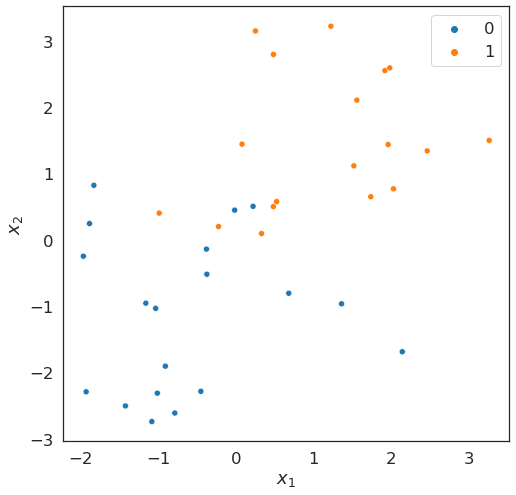

In [12]:
sns.set_style('white')
f = plt.figure(figsize=(8,8))
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth':2.5})

sns.scatterplot(data=x_train, x=x_train[:,-2], y=x_train[:,-1],hue=y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [13]:
lsc = LeastSquareClassification()

#### Normal Equation
Let's learn the model parameters through normal equation method

Weight vector: [[ 0.56628836  0.43371164]
 [-0.11044047  0.11044047]
 [-0.17810548  0.17810548]]


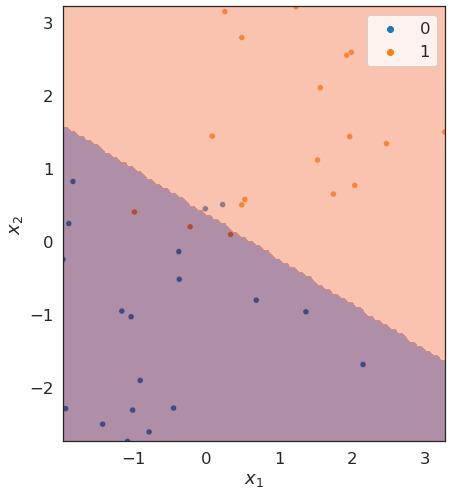

In [14]:
lsc.fit(x_train, y_train_trans, reg_rate=0)
print('Weight vector:',lsc.w)
visualize_model(x_train, y_train, lsc)

In [15]:
def plot_learning_curve(err_all):
    err = [err[1][1] for err in err_all]
    plt.plot(np.arange(len(err)), err, 'r-')
    plt.xlabel('Iter #')
    plt.ylabel('$\mathbf{J(w)}$')

#### GD

In [16]:
lsc = LeastSquareClassification()
lsc.gd(x_train, y_train_trans, num_epochs=100, reg_rate=0, lr=1e-3)

array([[ 0.55065554,  0.42238757],
       [-0.10545632,  0.11448772],
       [-0.1799707 ,  0.17643352]])

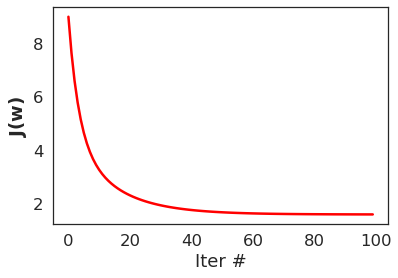

In [17]:
plot_learning_curve(err_all=lsc.err_all)

#### SGD
Let's train the model with SGD and examine the learning curve

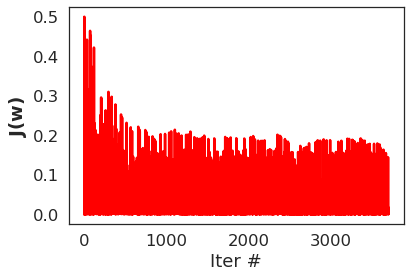

In [18]:
lsc.sgd(x_train, y_train_trans, num_epochs=100, reg_rate=0)
plot_learning_curve(lsc.err_all)

Let's visualize the decision boundary

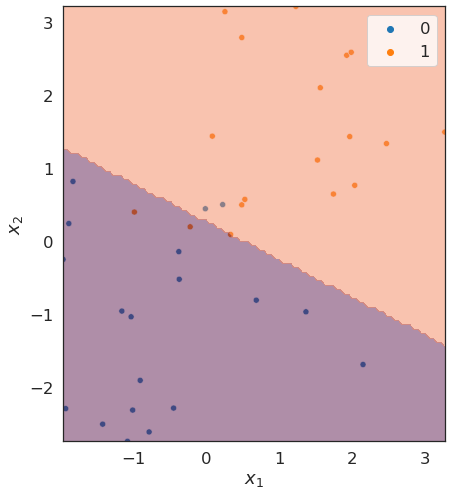

In [19]:
visualize_model(x_train, y_train, lsc)

#### MBGD

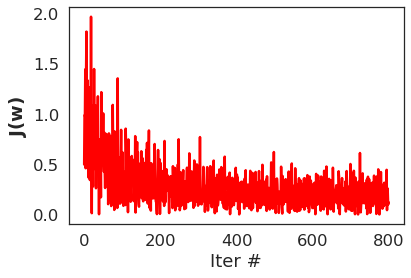

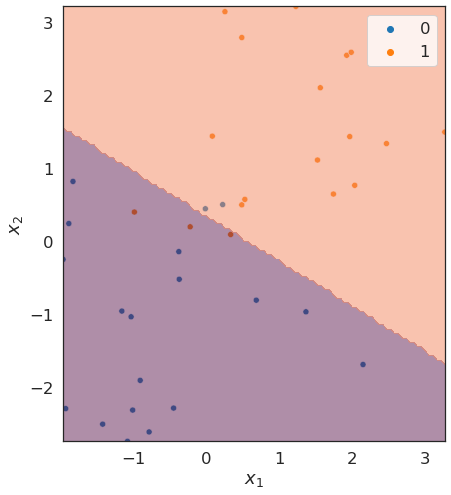

In [20]:
lsc.mbgd(x_train, y_train_trans, num_epochs=100, batch_size=5, reg_rate=0)
plot_learning_curve(lsc.err_all)
visualize_model(x_train, y_train, lsc)

#### Evaluation metrics

In [21]:
print(x_test.shape)
y_test_hat = lsc.predict(x_test)

(13, 3)


Get counts of true positives and negatives, false positives and negatives

In [22]:
tp = np.where((y_test == 1) & (y_test_hat == 1), 1, 0).sum()
tn = np.where((y_test == 0) & (y_test_hat == 0), 1, 0).sum()
fp = np.where((y_test == 0) & (y_test_hat == 1), 1, 0).sum()
fn = np.where((y_test == 1) & (y_test_hat == 0), 1, 0).sum()
print(tp,tn,fp,fn)

6 5 1 1


In [23]:
def precision(tp, fp):
    if tp + fp == 0:
        return None
    return tp/(tp+fp)

In [24]:
def recall(tp, fn):
    if tp + fn == 0:
        return None
    return tp/(tp+fn)

In [25]:
def accuracy(tp, fp, tn, fn):
    return (tp + tn)/(tp + tn + fp + fn)

In [26]:
def f1_score(pr, r):
    if pr == None or r == None:
        return None
    return 2*(pr * r)/(pr + r)

#### Classification metrics

In [27]:
pr = precision(tp, fp)
r = recall(tp, fn)
print('Precision:', pr)
print('Recall:', r)
print('Accuracy:', accuracy(tp, fp, tn, fn))
print('F-1 Score:', f1_score(pr, r))

Precision: 0.8571428571428571
Recall: 0.8571428571428571
Accuracy: 0.8461538461538461
F-1 Score: 0.8571428571428571


### Demo# 2: Linearly seperable binary classification with outliers
In the second demonstration, we show that the least square classifier is influenced by the presence of outliers in the dataset.

In [28]:
 x_train, x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess(add_outliers=True)

We add five outliers in one class and check what happens to the classification boundary

In [29]:
print('\nShape of training feature matrix:', x_train.shape)
print('Shape of training label vector:', y_train.shape)

print('\nShape of test feature matrix:', x_test.shape)
print('Shape of test label vector:', y_test.shape)


Shape of training feature matrix: (41, 3)
Shape of training label vector: (41,)

Shape of test feature matrix: (14, 3)
Shape of test label vector: (14,)


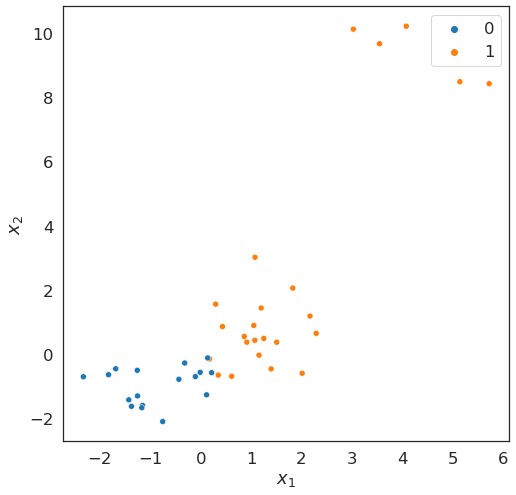

In [30]:
sns.set_style('white')
f = plt.figure(figsize=(8,8))
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth':2.5})

sns.scatterplot(data=x_train, x=x_train[:,-2], y=x_train[:,-1],hue=y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

The next step is to learn LeastSquare classification model on this data and check if it is affected due to the presence of outliers.

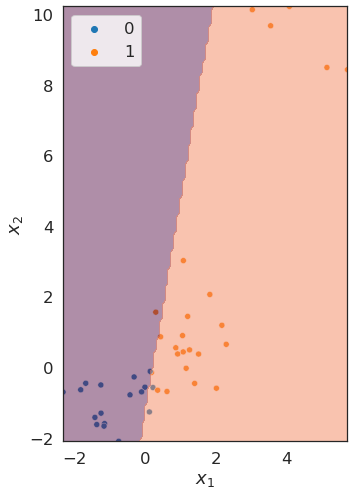

In [31]:
lsc_outlier = LeastSquareClassification()
lsc_outlier.fit(x_train, y_train_trans, reg_rate=0)
visualize_model(x_train, y_train, lsc_obj=lsc_outlier)

Compare the decision boundary with the earlier one learnt without any outliers

**Question**: Try iterative optimization methods on this setup and check the outcome.

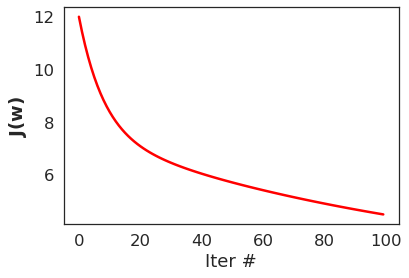

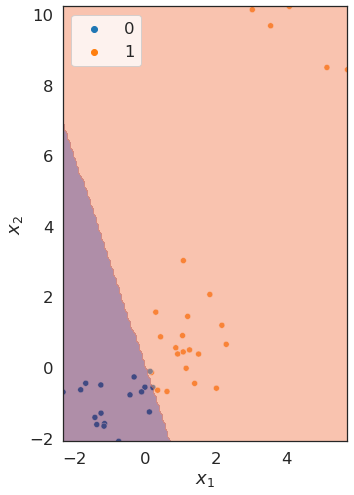

In [32]:
#GD
lsc_outlier.gd(x_train, y_train_trans, num_epochs=100, lr= 0.0001, reg_rate=0)
plot_learning_curve(lsc_outlier.err_all)
visualize_model(x_train, y_train, lsc_outlier)

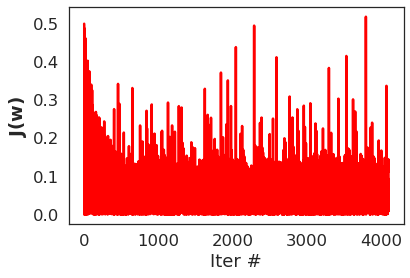

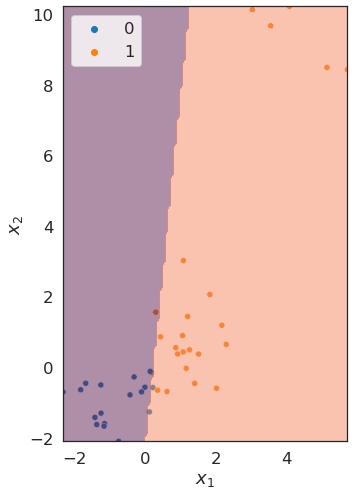

In [33]:
#SGD
lsc_outlier.sgd(x_train, y_train_trans, num_epochs=100, reg_rate=0)
plot_learning_curve(lsc_outlier.err_all)
visualize_model(x_train, y_train, lsc_outlier)

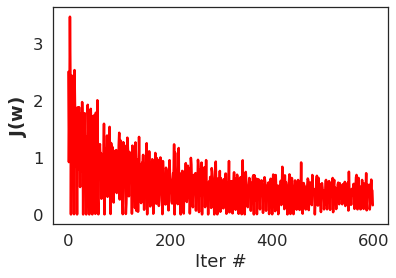

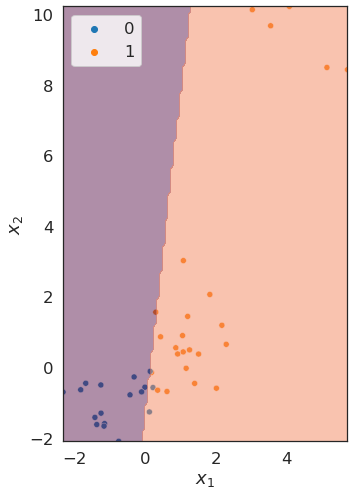

In [34]:
#MBGD
lsc_outlier.mbgd(x_train, y_train_trans, num_epochs=100, batch_size=8, reg_rate=0)
plot_learning_curve(lsc_outlier.err_all)
visualize_model(x_train, y_train, lsc_outlier)

### Demo# 3: Multi-class setup
In this setup, we demonstrate multi-class setup with three classes:

In [35]:
x_train, x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess(add_class=True)

Let's visualize the training set:

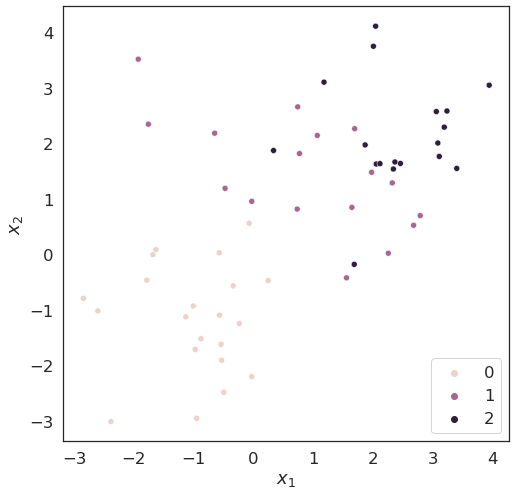

In [36]:
sns.set_style('white')
f = plt.figure(figsize=(8,8))
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth':2.5})

sns.scatterplot(data=x_train, x=x_train[:,-2], y=x_train[:,-1],hue=y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

Let's perform a sanity check to see if there are only three classes

In [37]:
np.unique(y_train)

array([0, 1, 2])

Now train the least square classifier and visualize the decision boundary.

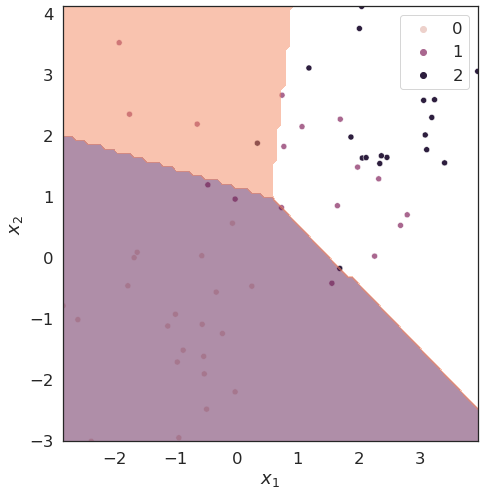

In [38]:
lsc_multi_class = LeastSquareClassification()
lsc_multi_class.fit(x_train, y_train_trans, reg_rate=1)
visualize_model(x_train, y_train, lsc_multi_class)

In [39]:
lsc_multi_class.w

array([[ 0.54712747,  0.25594808,  0.17613885],
       [-0.10458089, -0.02895392,  0.13582068],
       [-0.16232395,  0.09143272,  0.07345205]])

We will use ``classification_report`` from sklearn API for obtaining evaluation metrics for multi-class classification. This can be implemented from scratch by first calculating multi-class confusion matrix, followed by metric computations.

In [40]:
from sklearn.metrics import classification_report
y_test_pred = lsc_multi_class.predict(x_test)
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.25      0.40         8
           2       0.70      1.00      0.82         7

    accuracy                           0.68        19
   macro avg       0.76      0.75      0.65        19
weighted avg       0.80      0.68      0.62        19



### Demo #4: Polynomial least square classification
In this demonstration, we will generate points from two classes  such that decision boundary between them is circular(i.e non-linear)

In [41]:
from sklearn.datasets import make_circles
x, y = make_circles()

In [42]:
from sklearn.datasets import make_circles
x, y = make_circles()
x_poly = polynomial_transform(x, degree=3)
print(x_poly.shape)

(100, 10)


We will first transform the feature set to obtain the polynomial features of degree 2 and then train least square classifier on the transformed feature set.

In [43]:
x_poly = polynomial_transform(x, degree=2)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y)

In [44]:
print('Shape of feature matrix before transformation:', x.shape)
print('Shape of feature matrix after polynomial transformation of degree 2:', x_poly.shape)

Shape of feature matrix before transformation: (100, 2)
Shape of feature matrix after polynomial transformation of degree 2: (100, 6)


In [45]:
x[:5]

array([[ 0.06279052, -0.99802673],
       [ 0.06279052,  0.99802673],
       [-0.30901699,  0.95105652],
       [ 0.87630668,  0.48175367],
       [ 0.5831749 ,  0.54763768]])

In [46]:
x_poly[:5]

array([[ 1.        ,  0.06279052, -0.99802673,  0.00394265, -0.06266662,
         0.99605735],
       [ 1.        ,  0.06279052,  0.99802673,  0.00394265,  0.06266662,
         0.99605735],
       [ 1.        , -0.30901699,  0.95105652,  0.0954915 , -0.29389263,
         0.9045085 ],
       [ 1.        ,  0.87630668,  0.48175367,  0.7679134 ,  0.42216396,
         0.2320866 ],
       [ 1.        ,  0.5831749 ,  0.54763768,  0.34009297,  0.31936855,
         0.29990703]])

In [47]:
y_train_trans = LabelTransformer().encode(y_train)
y_test_trans = LabelTransformer().encode(y_test)

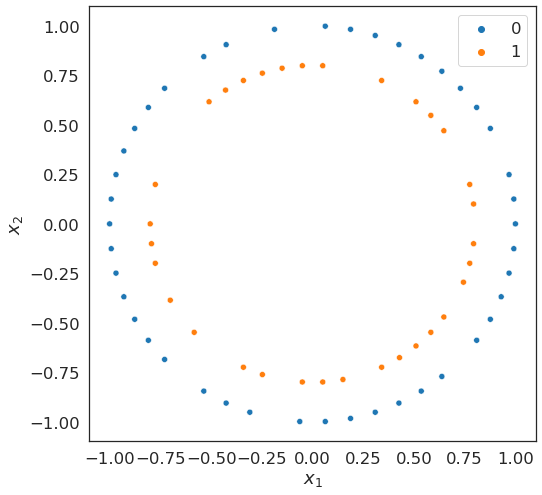

In [48]:
sns.set_style('white')
f = plt.figure(figsize=(8,8))
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth':2.5})

sns.scatterplot(data=x_train, x=x_train[:,1], y=x_train[:,2],hue=y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

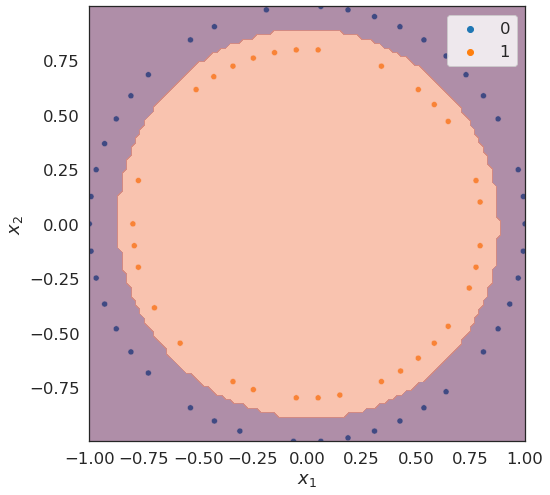

In [49]:
lsc_poly = LeastSquareClassification()
lsc_poly.fit(x_train, y_train_trans, reg_rate=1)
visualize_model(x_train, y_train, lsc_poly, degree=2)

Let's evaluate the performance of the classifier

In [50]:
from sklearn.metrics import classification_report
y_test_pred = lsc_poly.predict(x_test)
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        18

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



## Lecture 4.7: Demonstration of Perceptron
### Perceptron
In this notebook, we will implement perceptron algorithm from scratch.
### Summary of perceptron concepts
#### Training data
- Feature matrix: $\mathbf{X}_{n \times (m+1)}$ includes a dummy feature $x_0$ that is set to 1.
- Label vector: $\mathbf{y}_{n \times 1}$
> Note that perceptron can solve only **only binary classification** problems
#### Model
$$\begin{align}
    h_w : y &= \operatorname{sign}(\mathbf{w}^T\phi (\mathbf{x})) \\
    &=\operatorname{sign}(z)
\end{align}$$
where,
- $\mathbf{w}$ is a weight vector in $\mathbb{R}^{(m+1)}$
- $$ \operatorname{sign}(z) = \begin{cases}
    +1 \quad z \ge 0\\
    -1 \quad z \lt 0
    \end{cases}$$
#### Loss Function
$$\begin{align}
    \mathbf{J(w)} &= \sum_{i=1}^n e^{(i)} \\
    &= \sum_{i=1}^n \operatorname{max}(-h_w(\mathbf{x}^{(i)})y^{(i)},0)
\end{align}$$
#### Operation procedure ( Perceptron Update rule)
1. Initialize $\mathbf{w}^{(0)} =0$
2. For each training example $(\mathbf{x}^{(i)}, y^{(i)})$
   1. $\hat{y}^{(i)} = \operatorname{sign}(\mathbf{w}^T\mathbf{x}^{(i)})$ [Calculate the output value]
   2. $\mathbf{w}^{(t+1)} := \mathbf{w}^{(t)}+\alpha(y^{(i)}-\hat{y}^{(i)})\phi(\mathbf{x}^{(i)})$ [Update the weights]
> Linear separable examples leads to convergence of the algorithm with zero training loss, else it oscillates.
#### Evaluation metrics
- Confusion matrix
- Precision/Recall/F1
#### Implementation
Let's first import useful libraries for this implementation and visualization

In [51]:
#@title [Import libraries]
from IPython.display import display, Math, Latex
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(1234)
%matplotlib inline

We will use polynomial transformation code for feature transformation

In [52]:
#@title [Polynomial transformation]
import itertools
import functools

def get_combinations (x, degree):
    return itertools.combinations_with_replacement(x, degree)

def compute_new_features(items):
    # reduce (lambda x, y: x*y,[1,2,3,4,5]) calculates ((((1*2)*3)*4)*5)
    return functools.reduce(lambda x, y: x*y, items)

def polynomial_transform(x, degree, logging=False):
    # Converts to feature matrix
    if x.ndim == 1:
        x = x[:, None]
    x_t = x.transpose()
    features = [np.ones(len(x))] # Populates 1s as first feature for each example

    if logging:
        print("Input:", x)
    for degree in range(1,degree+1):
        for items in get_combinations(x_t, degree):
            features.append(compute_new_features(items))
            if logging:
                print(items, ":", compute_new_features(items))
    if logging:
        print(np.asarray(features).transpose())
    return np.asarray(features).transpose()

#### Perceptron class

In [53]:
class Perceptron:
    '''
    Implements perceptron class.
    It uses the following class variables.
    w: stores the final weight vector
    w_all: stores all the weight vector in training iterations
    errors_all: stores all the errors in training iterations
    '''

    def __init__(self):
        return
    
    def predict(self, X):
        '''
        Predict labels for input feature matrix X.
        '''
        z = X @ self.w
        return np.where(z >= 0, 1, -1)
    
    def loss(self, X, y):
        '''
        Calculates loss.
        
        Calculates loss due to current weight vector w on feature matrix X
        and label vector y.

        Args:
            X: feature matrix
            y: label vector
        
        Returns:
            None
        '''
        return np.sum(np.maximum(-1 * self.predict(X)*y, np.zeros(y.shape[0])))
    
    def train(self, X, y, w=None,epochs=10, lr=0.001):
        '''
        Implements perceptron update rule.

        Args:
            X: feature matrix
            y: Label vector
            epochs: Number of epochs
            lr: Learning rate
        Returns:
            None
        '''
        if w is None:
            self.w = np.zeros(X.shape[1])
        else:
            self.w = w
        self.errors_all = []
        self.w_all = []

        for _ in range(epochs):
            errors = 0
            for xi, target in zip(X, y):
                self.w += lr * (target - self.predict(xi))*xi
                errors += (max(-1 * self.predict(xi)*target, 0))
            
            self.errors_all.append(errors)
            self.w_all.append(self.w)

            print('w:', self.w)
            print('J(w):', self.errors_all[-1])
            # Note: Commented for loss visualization. Uncomment in actual implementation
            #if self.loss(X, y) == 0:
            #    break

#### Synthetic Data Generator

In [54]:
#@title Toy dataset creation
def create_toy_data(add_outliers=False, add_class=False):
    x0 = np.random.normal(size=50).reshape(-1, 2) - 2
    x1 = np.random.normal(size=50).reshape(-1, 2) + 2
    
    if add_outliers:
        x_1 = np.random.normal(size=10).reshape(-1, 2) + np.array([-3., -3.])
        return np.concatenate([x0, x1, x_1]), np.concatenate([-1*np.ones(25), np.ones(30)]).astype(int)

    if add_class:
        x2 = np.random.normal(size=50).reshape(-1, 2) + 2.
        return np.concatenate([x0, x1, x2]), np.concatenate([-1*np.ones(25), np.ones(25), 2+ np.zeros(25)]).astype(int)

    return np.concatenate([x0, x1]), np.concatenate([-1*np.ones(25), np.ones(25)]).astype(int)

#@title Data preprocessing
from sklearn.model_selection import train_test_split
def preprocess(add_class=False, add_outliers=False, degree=1):
    x, y = create_toy_data(add_outliers, add_class)
    x_poly = polynomial_transform(x, degree=degree)
    X_train, X_test, y_train, y_test = train_test_split(x_poly, y)
    y_train_trans  = LabelTransformer().encode(y_train)
    y_test_trans = LabelTransformer().encode(y_test)
    return X_train, X_test, y_train, y_test, y_train_trans, y_test_trans

#### Model visualization

In [55]:
#@title Model visualization

sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
def visualize_model(X_train, labels, lsc_obj, degree=1):
    
    f = plt.figure(figsize=(8,8))

    # compute xlim and ylim
    x1_min = np.min(X_train[:,1])
    x1_max = np.max(X_train[:,1])
    x2_min = np.min(X_train[:,2])
    x2_max = np.max(X_train[:,2])

    x1_test, x2_test = np.meshgrid(np.linspace(x1_min,x1_max,100), np.linspace(x2_min, x2_max, 100))
    x_test = np.array([x1_test, x2_test]).reshape(2, -1).T
    x_test_poly = polynomial_transform(x_test, degree=degree)
    y_test = lsc_obj.predict(x_test_poly)

    sns.scatterplot(data=X_train, x=X_train[:,1], y=X_train[:,2], hue=labels)
    plt.contourf(x1_test, x2_test, y_test.reshape(100, 100), alpha=0.5, levels=np.linspace(0,1,3))
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

### Demonstration
#### 1. Linearly seperable case

In [56]:
from sklearn.model_selection import train_test_split
x, y = create_toy_data()
x_poly = polynomial_transform(x, degree=1)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y)

w: [0.         8.89739191 5.35833659]
J(w): 0
w: [0.         8.89739191 5.35833659]
J(w): 0
w: [0.         8.89739191 5.35833659]
J(w): 0
w: [0.         8.89739191 5.35833659]
J(w): 0
w: [0.         8.89739191 5.35833659]
J(w): 0
w: [0.         8.89739191 5.35833659]
J(w): 0
w: [0.         8.89739191 5.35833659]
J(w): 0
w: [0.         8.89739191 5.35833659]
J(w): 0
w: [0.         8.89739191 5.35833659]
J(w): 0
w: [0.         8.89739191 5.35833659]
J(w): 0


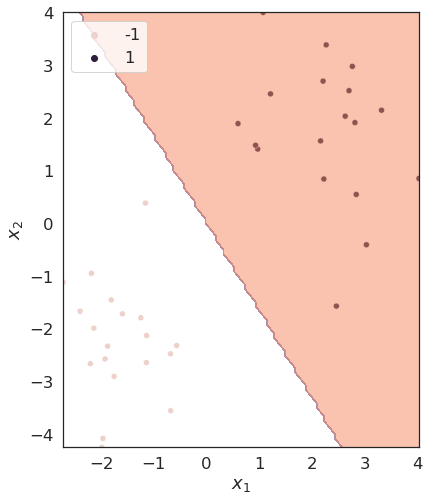

In [57]:
perceptron_obj = Perceptron()
perceptron_obj.train(x_train, y_train, lr=1)
visualize_model(x_train, y_train, perceptron_obj, degree=1)

In [58]:
perceptron_obj.errors_all

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Text(0.5, 1.0, 'Learning curve')

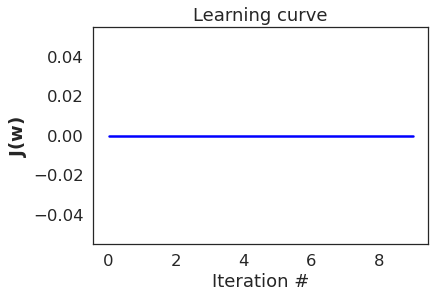

In [59]:
plt.plot(np.arange(len(perceptron_obj.errors_all)),perceptron_obj.errors_all, 'b-')
plt.xlabel('Iteration #')
plt.ylabel('$\mathbf{J(w)}$')
plt.title('Learning curve')

#### Linearly non seperable cases

w: [0.         0.00480494 0.00286481]
J(w): 1
w: [0.         0.00656169 0.00095656]
J(w): 0
w: [0.002      0.00604125 0.0018832 ]
J(w): 0
w: [ 2.00000000e-03  7.79799146e-03 -2.50504220e-05]
J(w): 0
w: [0.         0.00553243 0.00241843]
J(w): 0
w: [0.         0.00728918 0.00051018]
J(w): 0
w: [0.         0.00705828 0.00027046]
J(w): 0
w: [0.00000000e+00 6.82737698e-03 3.07312849e-05]
J(w): 0
w: [ 0.          0.00659648 -0.00020899]
J(w): 0
w: [ 0.          0.00636558 -0.00044872]
J(w): 0


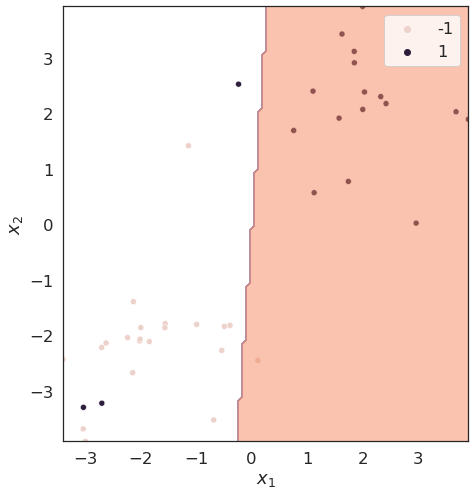

In [60]:
x, y = create_toy_data(add_outliers=True)
x_poly = polynomial_transform(x, degree=1)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y)
#print(y_train)

perceptron_obj = Perceptron()
perceptron_obj.train(x_train, y_train)
visualize_model(x_train, y_train, perceptron_obj, degree=1)

Text(0.5, 1.0, 'Learning curve')

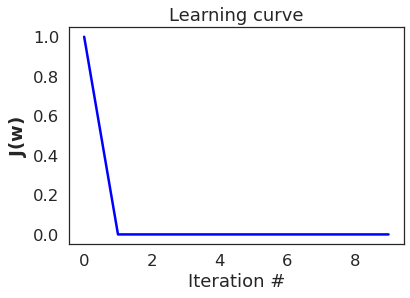

In [61]:
plt.plot(np.arange(len(perceptron_obj.errors_all)),perceptron_obj.errors_all, 'b-')
plt.xlabel('Iteration #')
plt.ylabel('$\mathbf{J(w)}$')
plt.title('Learning curve')

#### Non-linearly seperable case

In [62]:
from sklearn.datasets import make_circles
x, y = make_circles()

x_poly = polynomial_transform(x, degree=2)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y)

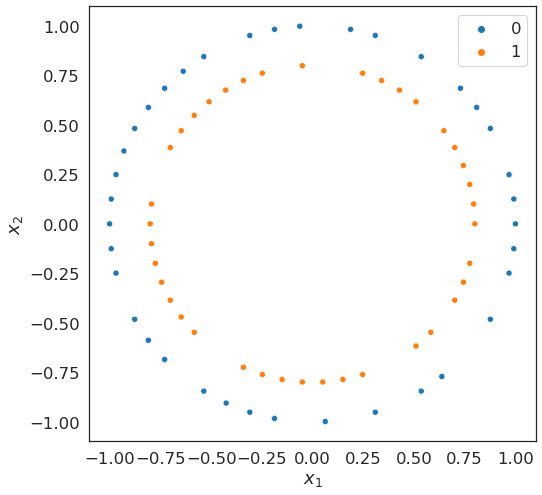

In [63]:
sns.set_style('white')
f = plt.figure(figsize=(8,8))
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth':2.5})

sns.scatterplot(data=x_train, x=x_train[:,1], y=x_train[:,2],hue=y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

w: [ 0.003       0.00129474 -0.00071512 -0.00166626  0.00171965 -0.00181374]
J(w): 0
w: [ 0.006      -0.00037597  0.00027114 -0.00395454  0.00224232 -0.00372546]
J(w): 0
w: [ 5.00000000e-03 -4.87313189e-04  8.93036607e-05 -6.04660803e-03
  4.25146664e-06 -4.79339197e-03]
J(w): 0
w: [ 0.006       0.0003579  -0.00032865 -0.00603166  0.00110734 -0.00452834]
J(w): 0
w: [ 0.005       0.00024267 -0.00090183 -0.0066399   0.00068092 -0.0056401 ]
J(w): 0
w: [ 6.00000000e-03  5.06639477e-05 -3.12688493e-04 -6.58924607e-03
  6.45934664e-04 -6.13075393e-03]
J(w): 0
w: [ 0.007      -0.0007409   0.00107557 -0.00649624 -0.00080354 -0.00666376]
J(w): 0
w: [ 8.00000000e-03 -2.81644939e-04 -3.73667667e-05 -7.54085552e-03
  8.99790701e-05 -6.05914448e-03]
J(w): 0
w: [ 7.00000000e-03 -1.23333979e-03 -1.33364974e-05 -7.85715680e-03
 -2.07142815e-03 -6.74284320e-03]
J(w): 0
w: [ 0.008       0.00182925 -0.00054692 -0.00745019 -0.00176421 -0.00614981]
J(w): 0


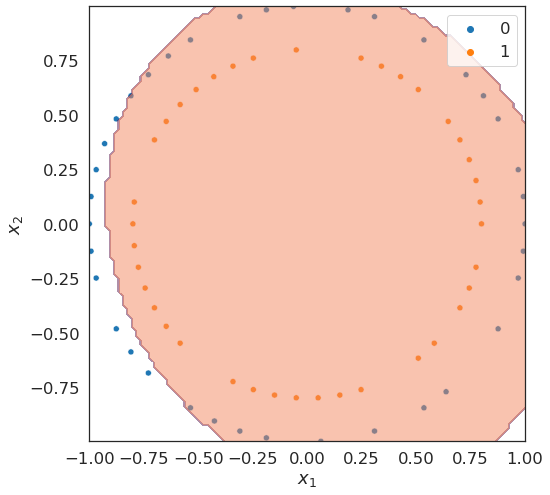

In [64]:
perceptron_poly = Perceptron()
perceptron_poly.train(x_train, y_train)
visualize_model(x_train, y_train, perceptron_poly, degree=2)